# Multiple sclerosis lesion prediction

Authors:
  + Karma Tarap
  + Alexander Noll
  
## Abstract

# Introduction

The goal of this work is to be able to localize lesions in multiple sclerosis (MS) patients. These lesions can be found mainly in the **white matter (WM)** tissue of the brain. Magnetic resonance imaging (MRI) is used to diagnose and monitor MS. The problem in using MRI in this image segmentation problem is that manual annotation of lesions is expensive and time consuming (a single MRI image consists of $512 \times 512 \times 512$ pixels). Also, there is variation in manual annotations between different physicians. 

This fact makes the problem at hand important to solve automatically, but also shows the problem: supervised machine learning usually requires a big number of labelled examples. Furthermore, only a relatively small proportion of the brain volume (~1.5%) is affected by a lesion and thus, the problem of lesion segmentation is **highly imbalanced**. 

Our approach to improving on this imbalance uses **Generative Adverserial Networks (GANs)** [Goodfellow, 2014](https://arxiv.org/abs/1406.2661) and **semi-supervised learning**. 

We train a a **deep convolutional GAN (DCGAN)** [Radford et al., 2015](https://arxiv.org/abs/1511.06434) on patches around lesion voxels. This allows us to generate volumes of brain mass that look similar to lesions. 

Then, we use **semi-supervised learning**. The general idea of semi-supervised learning is to provide, in addition to the labelled examples, also unlabelled examples. These unlabelled examples usually come from an unlabelled dataset that is "similar" to the dataset of interest. Alternatively, the unlabelled data can also be generated artificially with a GAN. 

In our case, we use semi-supervised learning by training a classification network that has three output classes:

1. No lesion: this is the negative class and is sampled from real MRI images.
2. True lesions: this is the positive class and is sampled from real MRI images as well.
3. Fake lesions: these come from the generative adverserial network above.

Using this technique, we can improve the classification accuracy by enhancing the original dataset with sampled new patches.

# Methods

## Deep convolutional networks
Convolutional neural networks have recently been shown to be the most powerful machine learning tool for TODO: find reference image classification and image segmentation

## Generative adversial networks

Generative adversial networks (GANs) have been described as one of the most promising ideas in deep learning. One of the main purposes of a GAN is that it allows one to sample data from arbitrary data. This can be achieved by leveraging a special kind of architecture. The main idea of this architecture is that it can be split into two parts:

1. **Generator**: The goal of the generator is to sample data that resemble the original data distribution. It usually starts by sampling random numbers from some distribution (for example, a multi-variate Gaussian in dimension 100). Then this input is upsampled using transposed convolutional layers (in the case of image or MRI generation) to generate output of the right size.
2. **Discriminator**: The discriminator is a classification model. Its goal is to distinguish data from the original data distribution from samples that were generated from the generator. Its architecture can vary from the problem, but usually consists of convolutional layers. It has been shown empirically **refernces needed** that **batch normalization** can greatly improve the overall performance of the GAN. Also, usually pooling layers are *not used* in the discriminator.

The discriminator has a farily standard loss, but with a small twist, for the classification problem described above: the discriminator loss is the cross entropy for the discriminator logits and predicting the correct class. One does, however, employ **label smoothing (REFERENCE NEEDED)**. This means that a real example has a label of $0.9$ instead of $1.0$. This has been shown empricially to give better results **REFERENCE NEEDED**.

Each of these sub-networks has its own loss function: the generator has a cross entropy loss such that being recognised by the discriminator as fake is punished. 

## Semi-supervised learning

## Dependencies

In the code chunk, all the libraries that are needed to replicate the results of this notebook are loaded. In the [github repo](https://github.com/NOllAl/CSCI82Project), the `requirements.txt` file specifies the detailed versions of the libraries.

In [2]:
import urllib.request
import os.path
import zipfile
import os
import numpy as np
import tensorflow as tf     
from matplotlib import pylab as plt
import SimpleITK as sitk
import nibabel as nib

%matplotlib inline

# Data

We mainly use the [2008 MICCAI MS Lesion Segmentation Challenge](https://www.nitrc.org/projects/msseg/) dataset. Note that this dataset is rather large (41GB), so when replicating the results, please make sure that enough disk space is available. 

The dataset was downloaded from the website above and uploaded to an S3 bucket for easy access. The next code chunk downloads this dataset to the local drive. When the code is executed on an EC2 machine in N. Virgina, the download should take around 5 minutes.

In [61]:



files = ['https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part3.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_train_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_train_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_test1_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_test1_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_train_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_train_Part2.zip']

def download_and_unzip(url):
    """
    Downloads and extracts file from S3 bucket. After extraction, the zip file is deleted.
    """
    folder = url[51:66]
    target_file = os.path.join('data', folder + '.zip')
    urllib.request.urlretrieve(url, target_file)    
    
    zip_ref = zipfile.ZipFile(target_file, 'r')
    zip_ref.extractall(os.path.join('data', folder))
    zip_ref.close()
    
    os.remove(target_file)
    
#for file in files: 
 #   download_and_unzip(file)

A sample scan from the University of North Carolina (UNC)

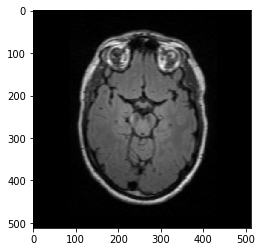

In [62]:

A = np.fromfile('./data/UNC_train_Part1/UNC_train_Case01/UNC_train_Case01_FLAIR.raw', dtype='int16', sep="")
A = A.reshape([512, 512, 512])
plt.imshow(A[197, :, :], cmap='gray')

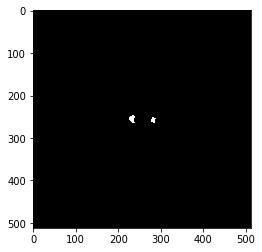

In [56]:

A = np.fromfile('./data/UNC_train_Part1/UNC_train_Case01/UNC_train_Case01_lesion.raw', dtype='int16', sep="")
A = A.reshape([512, 512, 512])
plt.imshow(A[197, :, :], cmap='gray')

In addition to RAW files, nhdr files were also provided. These can be read in with the SimpleITK package and provide additional metadata on the MRI scans

This time we will look at scans from the other hospital in the database - Children’s Hospital Boston (CHB). In total we have segmented scans from 20 patients.

In [74]:
B_FLAIR = sitk.ReadImage('./data/CHB_train_Part1/CHB_train_Case01/CHB_train_Case01_FLAIR.nhdr')

#Setting size of dimensions from image metadata
HEIGHT = B_FLAIR.GetHeight()
WIDTH  = B_FLAIR.GetWidth()
DEPTH  = B_FLAIR.GetDepth()
 
B_T1 = sitk.ReadImage('./data/CHB_train_Part1/CHB_train_Case01/CHB_train_Case01_T1.nhdr')
B_T2 = sitk.ReadImage('./data/CHB_train_Part1/CHB_train_Case01/CHB_train_Case01_T2.nhdr')
B_lesion = sitk.ReadImage('./data/CHB_train_Part1/CHB_train_Case01/CHB_train_Case01_lesion.nhdr')


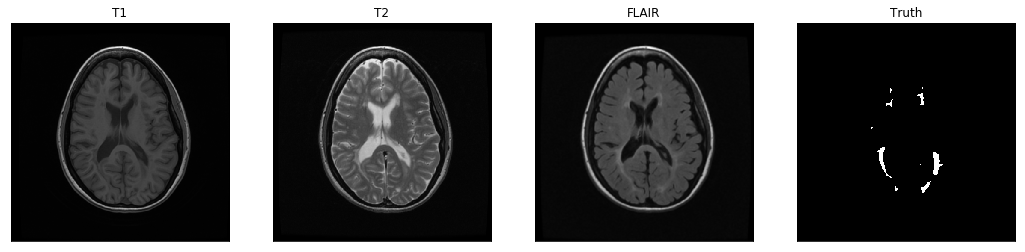

In [94]:
import matplotlib as mpl
mpl.rc('image', aspect='equal')

def show_slice(img,slice,ax,title=None,mapp="gray"):
    #transfor to array
    nda = sitk.GetArrayViewFromImage(img)
    if(title):
        plt.title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(nda[slice,:,:], cmap=mapp)
    
# Set depth of slice from middle of scan
z = DEPTH // 2
fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(1,4,1)
show_slice(B_T1,z,ax1,"T1")

ax2 = fig.add_subplot(1,4,2)
show_slice(B_T2,z,ax2,"T2")

ax3 = fig.add_subplot(1,4,3) 
show_slice(B_FLAIR,z,ax3,"FLAIR")

ax4 = fig.add_subplot(1,4,4)
show_slice(B_lesion,z,ax4,"Truth")

The above are all MRI slices of the same patient (in this case most likely a child). A rather naiive explanation of the images are as follows:

T1: Tissues with short T1 appear brighter than tissues with longer T1; so, fat is brightest, followed by white and gray matter, and CSF has the lowest signal. Lesions appear black.

T2: Tissues with long T2 appear brighter than tissues with shorter T2; so, CSF is brightest, followed by gray matter, and white matter; muscle appears darkest. Lesions appear white.

FLAIR: fluid-attenuated inversion-recovery MRI: bright signal of the CSF (cerebrospinal fluid) is suppressed which allows a better detection of small hyperintense lesions. Lesions should be bright.

Truth: Ground truth from professionals.

In [25]:
#Launch 3d visualisation, not possible from AWS

%env SITK_SHOW_COMMAND '/Applications/Slicer.app/Contents/MacOS/Slicer'
try:
    sitk.Show(B_T1)
except RuntimeError:
    print('SimpleITK Show method could not find the viewer (Slicer not installed or ' +
          'environment variable pointing to non existant viewer).')

env: SITK_SHOW_COMMAND='/Applications/Slicer.app/Contents/MacOS/Slicer'
SimpleITK Show method could not find the viewer (Slicer not installed or environment variable pointing to non existant viewer).


In [27]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)
        
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    myshow(img, title, margin, dpi)


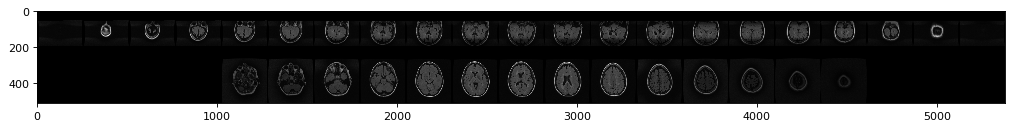

In [31]:
# A cross sample of scans every 20 slices
myshow3d(B_FLAIR,yslices=range(50,WIDTH-50,20), zslices=range(50,DEPTH-50,20))

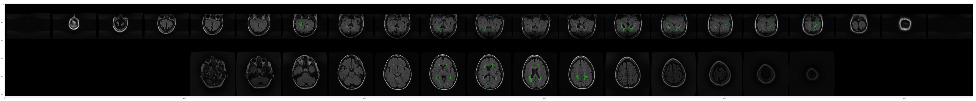

In [37]:
rescaled_FLAIR = sitk.Cast(sitk.RescaleIntensity(B_FLAIR), sitk.sitkUInt8)
O_FLAIR = sitk.LabelOverlay(rescaled_FLAIR, B_lesion, 0.5)
myshow3d(O_FLAIR,
         yslices=range(50, WIDTH - 50, 20),
         zslices=range(50, DEPTH - 50, 20),
         dpi=10)

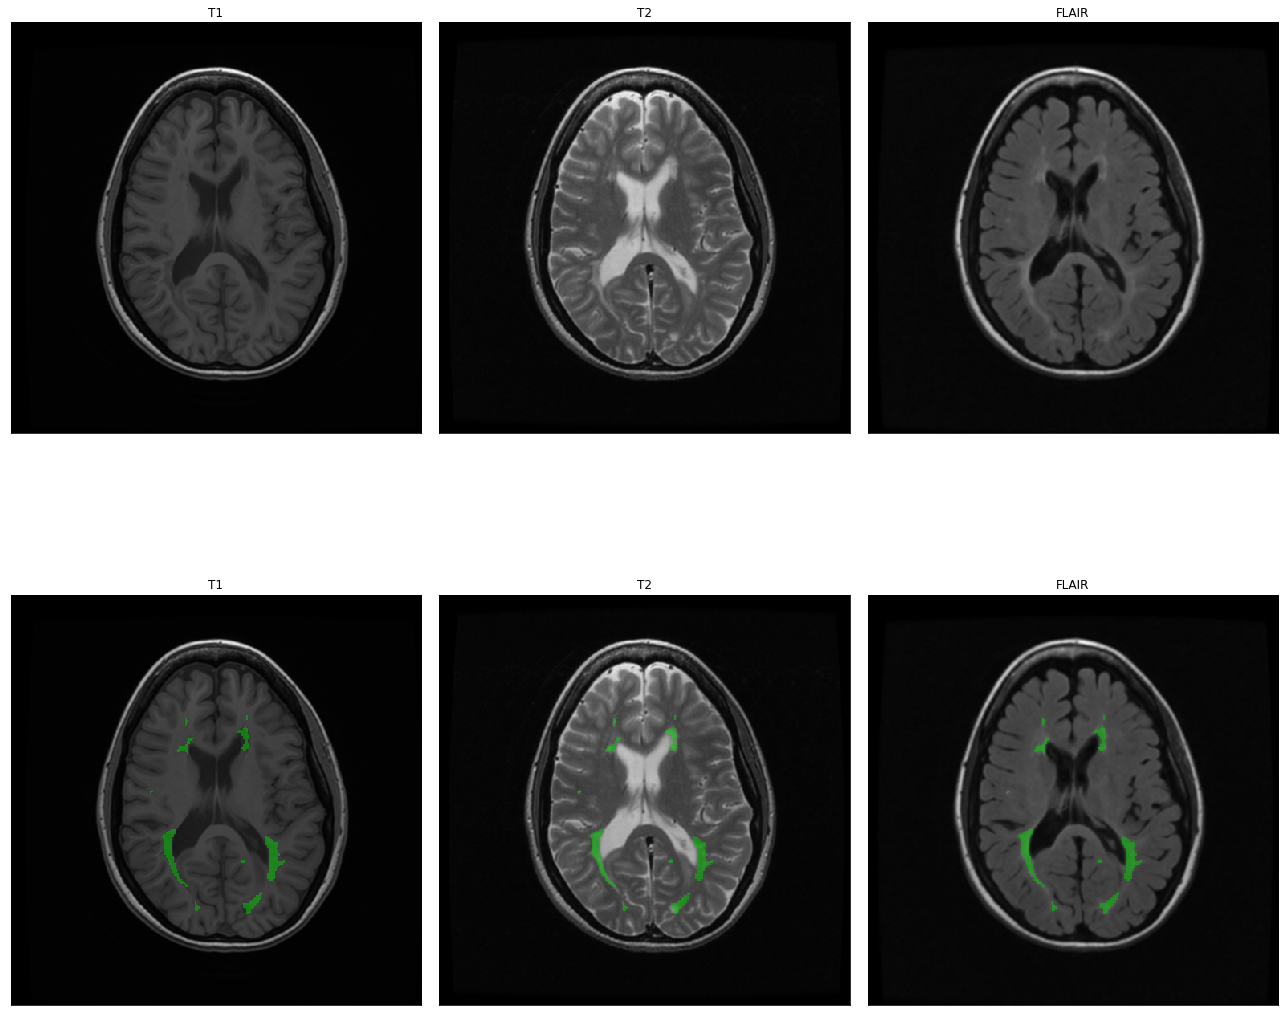

In [96]:
fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(2,3,1)
show_slice(B_T1,z,ax1,"T1")
ax1 = fig.add_subplot(2,3,2)
show_slice(B_T2,z,ax1,"T2")
ax1 = fig.add_subplot(2,3,3)
show_slice(B_FLAIR,z,ax1,"FLAIR")


ax1 = fig.add_subplot(2,3,4)
r_T1 = sitk.Cast(sitk.RescaleIntensity(B_T1), sitk.sitkUInt8)
o_T1 = sitk.LabelOverlay(r_T1, B_lesion, 0.5)
show_slice(o_T1,z,ax1,"T1")

ax1 = fig.add_subplot(2,3,5)
r_T2= sitk.Cast(sitk.RescaleIntensity(B_T2), sitk.sitkUInt8)
o_T2 = sitk.LabelOverlay(r_T2, B_lesion, 0.5)
show_slice(o_T2,z,ax1,"T2")

ax1 = fig.add_subplot(2,3,6)
r_FLAIR = sitk.Cast(sitk.RescaleIntensity(B_FLAIR), sitk.sitkUInt8)
o_FLAIR = sitk.LabelOverlay(r_FLAIR, B_lesion, 0.5)
show_slice(o_FLAIR,z,ax1,"FLAIR")
plt.tight_layout(h_pad=0)


## Generative Adverserial Network

In the following, we define the architecture of the generative adverserial network and train it. The implementation is done in `TensorFlow`. We split the set of MRI scans into a training and cross validation dataset. The same split will later be maintained when we do the image segmentation. Splitting here may or may not be necessary, but in any case, it can avoid a possible information leakage from the training set. When submitting the final results, of course, both the GAN and the segmentation models are retrained on the entire dataset.

### Data Generator

We start with the task of writing a custom training generator. In order to achieve that, we first store the locations of all MRI files that we will be using in a list. We split this list into a training and validation set. Afterwards, a helper function is defined which allows to easily read in an MRI image by just specifying the path. This function is subsequently used to read in all the MRI files. Note that this will probably lead to problems on standard laptops or desktop PCs. This script was executed on Amazon Web Services (AWS) using `p2.xlarge` instance which has sufficient memory. 

In [178]:
import numpy as np

files = ['CHB_train_Part1/CHB_train_Case0' + str(i) + '/CHB_train_Case0' + str(i) for i in range(1, 6)]
files += ['CHB_train_Part2/CHB_train_Case0' + str(i) + '/CHB_train_Case0' + str(i) for i in range(6, 10)]
files += ['CHB_train_Part2/CHB_train_Case10/CHB_train_Case10']
files += ['UNC_train_Part1/UNC_train_Case0' + str(i) + '/UNC_train_Case0' + str(i) for i in range(1, 6)]
files += ['UNC_train_Part2/UNC_train_Case0' + str(i) + '/UNC_train_Case0' + str(i) for i in range(6, 10)]
files += ['UNC_train_Part2/UNC_train_Case10/UNC_train_Case10']
files = ['data/' + file for file in files]
train_files = np.random.choice(files, size=15, replace=False)
test_files = [file for file in files if file not in train_files]

In [179]:
def read_directory(image):
    """
    Reads the channels (FLAIR, T1, T2) of an MRI and the segmented lesions from a directory containing the MRI scan.
    
    :param image_dir: path containing the MRI scans
    """
    x = [np.fromfile(image + ending, dtype='float16', sep='') for ending in ['_FLAIR.raw', '_T1.raw', '_T2.raw']]
    x = [np.reshape(xx, (512, 512, 512)) for xx in x]
    x = np.stack(x)
    
    target_file = image + '_lesion.raw'
    target = np.reshape(np.fromfile(target_file, dtype='int16', sep=""), (512, 512, 512))
    return x, target

all_files = [read_directory(file) for file in train_files]

After reading in all MRI files, a training generator is defined. This training generator can be used to generate patches around a lesion voxel to be fed into the GAN. The training generator is parametrized by the `batch_size` which indicates the number of patches and by `patch_size` which parametrizes how many neighboring voxels will be incorporated into the sampled patch. 

The generator works as follows:

1. It samples `batch_size` training images (as defined above) with replacement.
2. For each sampled training image, it samples one lesion voxel and computes a region of the appropriate patch size around it. Here the implicit assumption is that the `patch_size` is small enough so that the patch around the voxel of interest is still in the interior of the brain. This assumption usually holds for small enough patch size (say 10). These sampled patches are returned.

In [63]:
def train_generator(train_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    """
    while True:

        # Loop over batches
        samples = []
        for i in range(batch_size):
            # Sample an image
            sampled_image = np.random.randint(len(train_images))
            x, y = train_images[sampled_image]

            # Sample a lesion voxel
            lesion_voxels = np.where(y == 1)
            sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
            sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))

            # Calculate sampled patch
            sampled_patch = x[:,
                              int(sampled_voxel[0] - patch_size / 2 + 1) : int(sampled_voxel[0] + patch_size / 2), 
                              int(sampled_voxel[1] - patch_size / 2 + 1) : int(sampled_voxel[1] + patch_size / 2),
                              int(sampled_voxel[2] - patch_size / 2 + 1) : int(sampled_voxel[2] + patch_size / 2)]

            samples.append(sampled_patch)

        results = np.stack(samples)
        yield results

In [64]:
batch_size = 10
patch_size = 14
foo = train_generator(all_files, batch_size=batch_size, patch_size=patch_size)

In [7]:
next(foo).shape

(10, 3, 13, 13, 13)

### GAN Architecture

We next procede to describe the architecture of the Generative Adverserial Network. 

#### Generator network

It works as follows:

1. We sample from an uncorrelated normal distribution of dimenison 100.
2. The so created random vector is passed through a fully connected layer of size $3\times 3\times 3\times 3 = 81$ and reshaped to (3, 3, 3, 3).
3. A [batch normalization](https://arxiv.org/abs/1502.03167) layer is applied.
4. Afterwards, we pass the output through a [leaky relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks).
5. This vector is upsampled with a three dimensional transposed convolution to size $(3, 6, 6, 6)$ using 'same' padding.
6. This output goes through a three-dimensional [transposed convolution](https://arxiv.org/abs/1603.07285).
7. Batch Normalization.
8. Leaky relu.
9. Another transposed convolution is applied with 'valid' padding.
10. Hyperbolic tangent.


In [8]:
def generator(z, reuse=False, alpha=0.2, training=True):
    """
    Defines the generator for the GAN.
    
    :param z: input tensor
    :param reuse: boolean used later to decide whether or not to reuse the weights
    :param alpha: alpha parameter of leaky relu
    :param training: parameter for batch normalization
    """
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 100*3*3*3)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (batch_size, 100, 3, 3, 3))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 100x3x3x3 now
        
        x2 = tf.layers.conv3d_transpose(x1, filters=50, kernel_size=2, strides=2, padding='same', data_format='channels_first')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 50x6x6x6 now
        
        x3 = tf.layers.conv3d_transpose(x2, 3, 3, strides=2, padding='valid', data_format='channels_first')
        # 3x13x13x13 now
        out = tf.tanh(x3)
        
        return out

#### Discriminator

In the next code chunke, the discriminator network is defined:

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Defines the tensors for the discriminator network.
    
    :param images: input images
    :param reuse: Boolean indicating if the weights should be reused
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 3x13x13x13x13
        z = tf.transpose(images, perm=[0, 2, 3, 4, 1])
        x1 = tf.layers.conv3d(z, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        print(relu1.shape)
        # Shape is 7x7x7x64
        
        x2 = tf.layers.conv3d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        # Shape is 4x4x4x128
        
        x3 = tf.layers.conv3d(relu2, filters=256, kernel_size=5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        # Shape is 2x2x2x256
        
        flat = tf.reshape(relu3, (-1, 2*2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

import tensorflow as tf        
tf.reset_default_graph()
z = tf.placeholder(tf.float32, shape=(None, 3, 13, 13, 13))
discriminator(z, reuse=False)

(?, 7, 7, 7, 64)


(<tf.Tensor 'discriminator/Sigmoid:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'discriminator/dense/BiasAdd:0' shape=(?, 1) dtype=float32>)

In [10]:
tf.reset_default_graph()
z_size = 100
inputs_z = tf.placeholder(tf.float32, (batch_size, z_size), name='input_z')
foo = generator(inputs_z)

#### Loss

The optimization goal of a GAN consists of two components:

1. The **discriminator** is supposed to be able to distinguish between the generated samples and the true samples. It thus needs a loss that is small when the discriminator can, in fact, distinguish between generated and true samples. Consequentially, a **cross entropy** loss is used to optimize the discrimintaor.
2. The **generator** needs a loss that is low when the discriminator is **not able** to distinguish between artificial and true samples. This is accomplished by setting reversing the labels in the generator loss below.

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

#### Optimizers

The optimizers are defined. We obtain two separate optimizers: one for optimizing the discriminator and one for optimizing the generator.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

#### Training

Finally, we define the method used for training the GAN. A couple of helper methods are defined there:

+ `model_inputs` defines the inputs
+ `show_generator_output` is a function to show the intermediate results of the training
+ `normalize` normalizes the input

In the actual training, we start by generating the graph. Then, we alternate between minimizing the loss of the discriminator and the loss of the generator. We require both of them to be below a certain threshold (1.0 and 0.6, respectively).

In [ ]:
def gan_inputs(image_size, z_dim):
    """
    Create the model inputs and learning rate placeholder.
    :param image_width: tuple of image dimensions
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real image inputs
    input_real = tf.placeholder(tf.float32, (None, *image_size), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return input_real, input_z, learning_rate

def show_generator_output(sess, input_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param input_z: Input Z Tensor
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.normal(0, 1, size=(batch_size, z_dim))
    samples = sess.run(
        generator(input_z, reuse=True, training=False),
        feed_dict={input_z: example_z})

    plt.figure()
    plt.imshow(samples[0, 0, 6, :, :], cmap='gray')
    plt.show()

def normalize(x):
    means = np.mean(x, axis=(2, 3, 4))
    means.shape=(batch_size, 3, 1, 1, 1)

    sds = np.std(x.astype(np.float32), axis=(2, 3, 4))
    sds.shape = (batch_size, 3, 1, 1, 1)
    return (x - means) / sds

In [ ]:
def train(epoch_count, batch_size, patch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param patch_size: patch size around center voxel
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    """
     
    input_real, input_z, learning_rate_tensor = gan_inputs(data_shape, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[0])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for i in range(steps_per_epoch):
                batch_images = next(get_batches)
                batch_images = normalize(batch_images)
                batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                
                while d_loss.eval({input_z: batch_z, input_real: batch_images}) > 0.6:
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                    batch_images = next(get_batches)
                    batch_images = normalize(batch_images)
                    batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                while g_loss.eval({input_z: batch_z}) > 0.6:
                    batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                    
                steps += 1
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:    
                    show_generator_output(sess, input_z)
        
        # Save the variables to disk.
        save_path = saver.save(sess, "/tmp/model.ckpt")
        print("Model saved in file: %s" % save_path)
        
        # Saving
        export_dir = './gan_generator/'
        builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
        builder.add_meta_graph_and_variables(sess, ["tag"], signature_def_map= {
        "gan": tf.saved_model.signature_def_utils.predict_signature_def(
                inputs = {"z": input_z},
                outputs = {"output": generator(input_z, reuse=True)})
            })
        builder.save()
                    

learning_rate = 0.00003
z_dim = 100
batch_size = 10
patch_size = 14
beta1 = 0.5
n_images = 10
print_every = 10
show_every = 10
data_shape = (3, 13, 13, 13)


epochs = 20
steps_per_epoch = 10
gen = train_generator(train_files, all_files, batch_size=batch_size, patch_size=patch_size)

with tf.Graph().as_default():
    train(epochs, batch_size, patch_size, z_dim, learning_rate, beta1, gen, data_shape)
    

To compare the generated brain segments with real segments, we show an example of a real region around a voxel. For the untrained human eye, it is hard to see problems in the training (maybe a specialist with medical expertise could immediately distinguish between our generated examples and true lesions).

In [ ]:
z_dim = 100
# loading
with tf.Session(graph=tf.Graph()) as sess:
    export_dir = './gan_generator/'
    tf.saved_model.loader.load(sess, ["tag"], export_dir)
    #print(tf.)
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("input_z:0")
    print(x.shape)
    #print([n.name for n in tf.get_default_graph().as_graph_def().node])
    model = graph.get_tensor_by_name("generator/Tanh:0")
    batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
    print(sess.run(model, {x: batch_z}))

## Classification

After training the generator, we can start training a neural network for the actual classification task. We start by writing a training generator. It works by randomly sampling (with equal probability) either a positive class (lesion), a negative class (no lesion) or a generated lesion. This gives a three class classification problem. Note that the class imbalance has already been taken care of with this sampling strategy.

## Semi-supervised learning

#### Batch generator

We define a batch generator for the lesion classification network as described above.

In [193]:
def batch_generator_inference(sample_images, all_images, batch_size, patch_size, sess, input_z, generator_output):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param train_images: list of sample images
    :param all_images: list of all images
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    :param sess: tensorflow session
    :param input_z: noise input to GAN generator
    :param generator_output: Output tensor from the GAN generator
    """
    while True:

        # Loop over batches
        samples = []
        targets = []
        im_size = all_images[0][1].shape
        for i in range(batch_size):
            # Sample target class: 0 is non-lesion, 1 is true lesion, 2 is generated lesion
            target = np.random.randint(0, 3)
            targets.append(target)
            
            if target in np.array([0, 1]):
                # Sample an image
                correct_sample = False
                while not correct_sample:
                    sampled_image = np.random.randint(len(all_images))
                    correct_sample = all_images[sampled_image][0] in sample_images
                    
                image_file, x, y = all_images[sampled_image]
                
                # Calculate lesion voxels
                if target == 1:
                    lesion_voxels = np.where(y == 1)
                    sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                    sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
                else:
                    lesion_voxels = np.where(y != 1)
                    sampled_boundary = True
                    
                    while sampled_boundary:
                        sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                        sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
                        small_range = np.all(np.array(sampled_voxel) > (patch_size / 2 + 1))
                        large_range = np.all(np.array(sampled_voxel) < (im_size[1] - patch_size / 2))
                        if small_range and large_range:
                            sampled_boundary = False
                            

                # Calculate sampled patch
                sampled_patch = x[:,
                              int(sampled_voxel[0] - patch_size / 2 + 1) : int(sampled_voxel[0] + patch_size / 2), 
                              int(sampled_voxel[1] - patch_size / 2 + 1) : int(sampled_voxel[1] + patch_size / 2),
                              int(sampled_voxel[2] - patch_size / 2 + 1) : int(sampled_voxel[2] + patch_size / 2)]
      
                
            else:
                z_dim = input_z.get_shape().as_list()[-1]
                example_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                
                sampled_patch = sess.run(generator_output, 
                                         feed_dict={input_z: example_z})
                
                sampled_patch = sampled_patch[0, :, :, :, :]
            


            samples.append(sampled_patch)

        results = np.stack(samples)
        target_results = np.array(targets)
        yield results, target_results

In [ ]:
batch_size = 10
patch_size = 14

# loading
with tf.Session(graph=tf.Graph()) as sess:
    export_dir = './gan_generator/'
    tf.saved_model.loader.load(sess, ["tag"], export_dir)
    graph = tf.get_default_graph()
    print("Model restored.")
    # Check the values of the variables
    input_z = graph.get_tensor_by_name("input_z:0")
    generator_output = graph.get_tensor_by_name("generator/Tanh:0")
    
    example_z = np.random.normal(0, 1, size=(batch_size, z_dim))
    gen = batch_generator_inference(train_files, all_files, batch_size, patch_size,
                                    sess, input_z, generator_output)
    
    images, targets = next(gen)

#### Classification architecture

The model is defined. It is a deep convolutional network quite similar to the discriminator as before. The only difference is in the final, fully connected layers: we return three outputs corresponding to the three classes (no lesion, real lesion, fake lesion). Also, we use **TODO: dropout layers for regularization**.

In [ ]:
def model(images, reuse=False, alpha=0.2):
    """
    Defines the tensors for the discriminator network.
    
    :param images: input images
    :param reuse: Boolean indicating if the weights should be reused
    """
    with tf.variable_scope('model', reuse=reuse):
        # Input layer is 3x13x13x13x13
        z = tf.transpose(images, perm=[0, 2, 3, 4, 1])
        x1 = tf.layers.conv3d(z, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # Shape is 7x7x7x64
        
        x2 = tf.layers.conv3d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        # Shape is 4x4x4x128
        
        x3 = tf.layers.conv3d(relu2, filters=256, kernel_size=5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        # Shape is 2x2x2x256
        
        flat = tf.reshape(relu3, (-1, 2*2*2*256))
        logits = tf.layers.dense(flat, 3)
        return logits

import tensorflow as tf        
tf.reset_default_graph()
z = tf.placeholder(tf.float32, shape=(None, 3, 13, 13, 13))
model(z, reuse=False)

#### Loss and optimizer

The loss is standard for classification tasks: it is a softmax cross entropy. The optimizer is an Adam optimizer. Also, a helper method is defined for getting the model inputs.

In [ ]:
def loss(x, y, depth=3):
    """
    Get the loss for the final model
    :param x: Images 
    :param y: label in (0, 1, 2)
    """
    y_one_hot = tf.one_hot(y, depth=depth)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=x, labels=y_one_hot))

    return loss

def opt(loss, learning_rate, beta1):
    """
    Get optimization operation
    :param loss: Model loss tensor
    :param learning_rate: learning rate tensor
    :param beta1: beta1 parameter for adam optimizer
    :return: Optimizer
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    m_vars = [var for var in t_vars if var.name.startswith('model')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list=m_vars)

    return train_opt

def model_inputs(image_size):
    """
    Create the model inputs and learning rate placeholder.
    :param image_width: tuple of image dimensions
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, learning rate, target)
    """
    # Real image inputs
    model_input = tf.placeholder(tf.float32, (None, *image_size), name='model_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    target = tf.placeholder(tf.int32, shape=(None), name='model_target')

    return model_input, learning_rate, target

#### Model training

In the following code chunk the main function doing the training of the classifier is deinfed. It first loads the graph from the GAN to be able to genereate fake lesions. Then it adds the new classifier to this graph. It iterates over `epoch_count` epochs and `steps_per_epoch` steps over the generator to optimize the loss. Intermediate results are shown in the console and in **TODO: Tensorboard**.

In [ ]:
def train_model(epoch_count, batch_size, patch_size, z_dim, learning_rate, beta1, get_batches, data_shape, depth):
    """
    Train the model
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param patch_size: patch size around center voxel
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param depth: number of unique target classes
    """
    export_dir = './gan_generator/'
    
    with tf.Session(graph=tf.Graph()) as sess:
        tf.saved_model.loader.load(sess, ["tag"], export_dir)
        graph = tf.get_default_graph()
        print("Model restored.")
        input_z = graph.get_tensor_by_name("input_z:0")
        generator_output = graph.get_tensor_by_name("generator/Tanh:0")
        gen = batch_generator_inference(train_files, all_files, batch_size, patch_size,
                                        sess, input_z, generator_output)
        
        # Inputs for classification model 
        model_input, learning_rate_tensor, target_tensor = model_inputs(data_shape)
        logits = model(model_input, reuse=False, alpha=0.2)
    
    
        # Loss and optimization tensor    
        loss_tensor = loss(logits, target_tensor, depth)
        opt_tensor = opt(loss_tensor, learning_rate, beta1)
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            train_loss = 0
            for i in range(steps_per_epoch):
                batch_images, batch_target = next(gen)
                #batch_images = normalize(batch_images)
                batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))

                _, delta_train_loss = sess.run([opt_tensor, loss_tensor],
                                               feed_dict={model_input: batch_images, input_z: batch_z,
                                                          target_tensor: batch_target})
                
                train_loss += delta_train_loss
                
                
            train_loss = train_loss / steps_per_epoch
            print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Loss: {:.4f}".format(train_loss))
    
        # Saving
        export_dir = './classifier/'
        builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
        builder.add_meta_graph_and_variables(sess, ["tag"], signature_def_map= {
        "classifier": tf.saved_model.signature_def_utils.predict_signature_def(
                inputs = {"x": model_input},
                outputs = {"y": logits})
            })
        builder.save()
                    

learning_rate = 0.0003
z_dim = 100
batch_size = 10
patch_size = 14
beta1 = 0.5
n_images = 10
data_shape = (3, 13, 13, 13)
depth = 3


epochs = 30
steps_per_epoch = 100

with tf.Graph().as_default():
    train_model(epochs, batch_size, patch_size, z_dim, learning_rate, beta1, gen, data_shape, depth)

# Conclusion

# References

In [169]:
def batch_generator_cnn(sample_images, all_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param train_images: list of sample images
    :param all_images: list of all images
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    """
    while True:

        # Loop over batches
        samples = []
        targets = []
        im_size = all_images[0][1].shape

        for i in range(batch_size):
            
            # Sample target class: 0 is non-lesion, 1 is true lesion, 2 is generated lesion
            target = np.random.randint(0, 2)

            # Sample an image
       
            sampled_image = np.random.randint(len(all_images))

          
            x, y = all_images[sampled_image]
 
            # Calculate lesion voxels
            if target == 1:
                lesion_voxels = np.where(y == 1)
                sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
            else:
                lesion_voxels = np.where(y != 1)
                sampled_boundary = True

                while sampled_boundary:
                    sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                    sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
                    small_range = np.all(np.array(sampled_voxel) > (patch_size / 2 + 1))
                    large_range = np.all(np.array(sampled_voxel) < (im_size[1] - patch_size / 2))
                    if small_range and large_range:
                        sampled_boundary = False


            # Calculate sampled patch
            x_lower = int(sampled_voxel[0] - patch_size / 2 + 1)
            x_upper = int(sampled_voxel[0] + patch_size / 2)
            
            y_lower = int(sampled_voxel[1] - patch_size / 2 + 1)
            y_upper = int(sampled_voxel[1] + patch_size / 2)

            z_lower = int(sampled_voxel[2] - patch_size / 2 + 1)
            z_upper = int(sampled_voxel[2] + patch_size / 2)
            
            sampled_patch = x[:,x_lower :x_upper, y_lower:y_upper, z_lower:z_upper]
            target_patch = y[x_lower :x_upper, y_lower:y_upper, z_lower:z_upper]
       
            samples.append(sampled_patch)
            targets.append(target_patch)

        results = np.stack(samples)
        target_results = np.stack(targets)
        target_results = np_utils.to_categorical(target_results,num_classes=3)
        target_results = np.swapaxes(target_results,1,4)
        yield results, target_results

In [184]:
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv3D, Conv3DTranspose
from keras.layers.convolutional import Cropping3D
from keras.layers.core import Permute
from keras.layers.core import Reshape
from keras.layers.merge import concatenate
from keras.models import Model
from keras import optimizers
from keras.utils import np_utils
K.set_image_dim_ordering('th')

from keras.layers.normalization import BatchNormalization

def generate_model(num_classes) :
    init_input = Input((3, 27, 27, 27))
    b = BatchNormalization()(init_input)

    x = Conv3D(25, kernel_size=(3, 3, 3))(b)
    x = PReLU()(x)
    x = Conv3D(25, kernel_size=(3, 3, 3))(x)
    x = PReLU()(x)
    x = Conv3D(25, kernel_size=(3, 3, 3))(x)
    x = PReLU()(x)

    y = Conv3D(50, kernel_size=(3, 3, 3))(x)
    y = PReLU()(y)
    y = Conv3D(50, kernel_size=(3, 3, 3))(y)
    y = PReLU()(y)
    y = Conv3D(50, kernel_size=(3, 3, 3))(y)
    y = PReLU()(y)

    z = Conv3D(75, kernel_size=(3, 3, 3))(y)
    z = PReLU()(z)
    z = Conv3D(75, kernel_size=(3, 3, 3))(z)
    z = PReLU()(z)
    z = Conv3D(75, kernel_size=(3, 3, 3))(z)
    z = PReLU()(z)

    x_crop = Cropping3D(cropping=((6, 6), (6, 6), (6, 6)))(x)
    y_crop = Cropping3D(cropping=((3, 3), (3, 3), (3, 3)))(y)

    concat = concatenate([x_crop, y_crop, z], axis=1)

    fc = Conv3D(400, kernel_size=(1, 1, 1))(concat)
    fc = PReLU()(fc)
    fc = Conv3D(200, kernel_size=(1, 1, 1))(fc)
    fc = PReLU()(fc)
    fc = Conv3D(150, kernel_size=(1, 1, 1))(fc)
    fc = PReLU()(fc)
    fc = Conv3DTranspose(64, (2, 2, 2), strides=(3, 3, 3), padding='same')(fc)
    pred = Conv3D(num_classes, kernel_size=(1, 1, 1))(fc)
    pred = PReLU()(pred)
  
    #pred = Reshape((num_classes, 27*27*27))(pred)
    #pred = Permute((2, 1))(pred)
    pred = Activation('softmax')(pred)

    model = Model(inputs=init_input,outputs=pred)
    sgd = optimizers.SGD(lr=0.01)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    return model


In [185]:
batch_size = 10
patch_size = 28
num_classes = 3 

In [186]:

model = generate_model(num_classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 3, 27, 27, 27 0                                            
__________________________________________________________________________________________________
conv3d_202 (Conv3D)             (None, 25, 25, 25, 2 2050        input_17[0][0]                   
__________________________________________________________________________________________________
p_re_lu_201 (PReLU)             (None, 25, 25, 25, 2 390625      conv3d_202[0][0]                 
__________________________________________________________________________________________________
conv3d_203 (Conv3D)             (None, 25, 23, 23, 2 16900       p_re_lu_201[0][0]                
__________________________________________________________________________________________________
p_re_lu_20

In [192]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(
    filepath="cnn.hdf5",
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=0, 
    verbose=0, 
    mode='auto')

callbacks = [checkpointer]

train_generator = batch_generator_cnn(train_files, all_files, batch_size, patch_size)
valid_generator = batch_generator_cnn(test_files, all_files, batch_size, patch_size)


history = model.fit_generator(train_generator, 
                    nb_epoch = 15,
                    steps_per_epoch=1,
                    validation_steps = 2,
                    validation_data=valid_generator,
                    callbacks = callbacks)




/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1, validation_steps=2, validation_data=<generator..., callbacks=[<keras.ca..., epochs=15)`


Epoch 1/15
1/1 [==============================] - 61s 61s/step - loss: 29.6625 - acc: 0.8437 - val_loss: 29.6625 - val_acc: 0.8681
Epoch 2/15
1/1 [==============================] - 32s 32s/step - loss: 29.6625 - acc: 0.8112 - val_loss: 29.6625 - val_acc: 0.7566
Epoch 3/15
1/1 [==============================] - 36s 36s/step - loss: 29.6625 - acc: 0.7899 - val_loss: 29.6625 - val_acc: 0.7885
Epoch 4/15
1/1 [==============================] - 40s 40s/step - loss: 29.6625 - acc: 0.8520 - val_loss: 29.6625 - val_acc: 0.8610
Epoch 5/15
1/1 [==============================] - 32s 32s/step - loss: 29.6625 - acc: 0.8012 - val_loss: 29.6625 - val_acc: 0.8065
Epoch 6/15
1/1 [==============================] - 39s 39s/step - loss: 29.6625 - acc: 0.8638 - val_loss: 29.6625 - val_acc: 0.8258
Epoch 7/15
1/1 [==============================] - 36s 36s/step - loss: 29.6625 - acc: 0.8169 - val_loss: 29.6625 - val_acc: 0.8002
Epoch 8/15
1/1 [==============================] - 40s 40s/step - loss: 29.6625 - ac

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


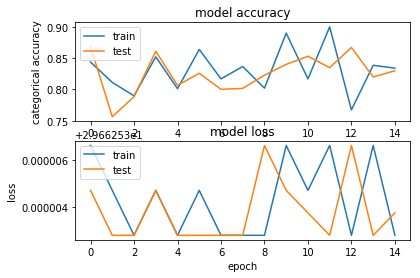

In [195]:
print(history.history.keys())  

plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('categorical accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

In [220]:
from keras.utils import normalize,np_utils
def batch_generator_cnn(sample_images, all_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param train_images: list of sample images
    :param all_images: list of all images
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    :param sess: tensorflow session
    :param input_z: noise input to GAN generator
    :param generator_output: Output tensor from the GAN generator
    """
    while True:

        # Loop over batches
        samples = []
        targets = []
        im_size = all_images[0][1].shape
        for i in range(batch_size):
            # Sample target class: 0 is non-lesion, 1 is true lesion, 2 is generated lesion
            target = np.random.randint(0, 2)
            targets.append(target)
            
            # Sample an image
            sampled_image = np.random.randint(len(all_images))
            x, y = all_images[sampled_image]
                
            # Calculate lesion voxels
            if target == 1:
                lesion_voxels = np.where(y == 1)
                sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
            else:
                lesion_voxels = np.where(y != 1)
                sampled_boundary = True

                while sampled_boundary:
                    sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                    sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
                    small_range = np.all(np.array(sampled_voxel) > (patch_size / 2 + 1))
                    large_range = np.all(np.array(sampled_voxel) < (im_size[1] - patch_size / 2))
                    if small_range and large_range:
                        sampled_boundary = False


            # Calculate sampled patch
            sampled_patch = x[:,
                          int(sampled_voxel[0] - patch_size / 2 + 1) : int(sampled_voxel[0] + patch_size / 2), 
                          int(sampled_voxel[1] - patch_size / 2 + 1) : int(sampled_voxel[1] + patch_size / 2),
                          int(sampled_voxel[2] - patch_size / 2 + 1) : int(sampled_voxel[2] + patch_size / 2)]

            samples.append(normalize(sampled_patch))

        results = np.stack(samples)
        target_results = np_utils.to_categorical(targets)
        yield results, target_results

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise c

In [238]:
#predict and test an image
from keras import backend as K
from keras.layers import Activation, Dense, Flatten
from keras.layers import Input
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv3D, Conv3DTranspose
from keras.layers.convolutional import Cropping3D
from keras.layers.core import Permute
from keras.layers.core import Reshape
from keras.layers.merge import concatenate
from keras.models import Model
from keras import optimizers
from keras.utils import np_utils
K.set_image_dim_ordering('th')

from keras.layers.normalization import BatchNormalization

def generate_model(num_classes) :
    init_input = Input((3, 27, 27, 27))
    b = BatchNormalization()(init_input)

    x = Conv3D(25, kernel_size=(3, 3, 3))(b)
    x = PReLU()(x)
    x = Conv3D(25, kernel_size=(3, 3, 3))(x)
    x = PReLU()(x)
    x = Conv3D(25, kernel_size=(3, 3, 3))(x)
    x = PReLU()(x)

    y = Conv3D(50, kernel_size=(3, 3, 3))(x)
    y = PReLU()(y)
    y = Conv3D(50, kernel_size=(3, 3, 3))(y)
    y = PReLU()(y)
    y = Conv3D(50, kernel_size=(3, 3, 3))(y)
    y = PReLU()(y)

    z = Conv3D(75, kernel_size=(3, 3, 3))(y)
    z = PReLU()(z)
    z = Conv3D(75, kernel_size=(3, 3, 3))(z)
    z = PReLU()(z)
    z = Conv3D(75, kernel_size=(3, 3, 3))(z)
    z = PReLU()(z)

    x_crop = Cropping3D(cropping=((6, 6), (6, 6), (6, 6)))(x)
    y_crop = Cropping3D(cropping=((3, 3), (3, 3), (3, 3)))(y)

    concat = concatenate([x_crop, y_crop, z], axis=1)

    fc = Conv3D(400, kernel_size=(1, 1, 1))(concat)
    fc = PReLU()(fc)
    fc = Conv3D(200, kernel_size=(1, 1, 1))(fc)
    fc = PReLU()(fc)
    fc = Conv3D(150, kernel_size=(1, 1, 1))(fc)
    fc = PReLU()(fc)
    #fc = Conv3DTranspose(64, (2, 2, 2), strides=(3, 3, 3), padding='same')(fc)
    pred = Conv3D(num_classes, kernel_size=(1, 1, 1))(fc)
    pred = PReLU()(pred)
    pred = Flatten()(pred)
    #pred = Reshape((2, 9*9*9))(pred)
    #pred = Permute((2, 1))(pred)
    
    pred = Dense(2)(pred)
    pred = Activation('sigmoid')(pred)
    
    adam = optimizers.Adam(lr=.0001)
    model = Model(inputs=init_input,outputs=pred)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['accuracy'])
    return model
model = generate_model(num_classes)
model.summary()


/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise c

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 3, 27, 27, 27 0                                            
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 3, 27, 27, 27 108         input_33[0][0]                   
__________________________________________________________________________________________________
conv3d_410 (Conv3D)             (None, 25, 25, 25, 2 2050        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
p_re_lu_409 (PReLU)             (None, 25, 25, 25, 2 390625      conv3d_410[0][0]                 
__________________________________________________________________________________________________
conv3d_411

In [239]:

checkpointer = ModelCheckpoint(
    filepath="cnn.hdf5",
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=0, 
    verbose=0, 
    mode='auto')


batch_size = 10
patch_size = 28

callbacks = [checkpointer]

train_generator = batch_generator_cnn(train_files, all_files, batch_size, patch_size)
valid_generator = batch_generator_cnn(test_files, all_files, batch_size, patch_size)

history = model.fit_generator(train_generator, 
                    nb_epoch = 15,
                    steps_per_epoch=1,
                    validation_steps = 2,
                    validation_data=valid_generator,
                    callbacks = callbacks)

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps

Epoch 1/15
1/1 [==============================] - 77s 77s/step - loss: 0.6892 - acc: 0.5000 - val_loss: 0.6927 - val_acc: 0.6500
Epoch 2/15
1/1 [==============================] - 44s 44s/step - loss: 0.6756 - acc: 0.9000 - val_loss: 0.6920 - val_acc: 0.6000
Epoch 3/15
1/1 [==============================] - 53s 53s/step - loss: 0.6790 - acc: 0.6000 - val_loss: 0.6930 - val_acc: 0.4500
Epoch 4/15


KeyboardInterrupt: 

In [244]:
def batch_generator_debug(sample_images, all_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param train_images: list of sample images
    :param all_images: list of all images
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    """
    while True:

        # Loop over batches
        samples = []
        targets = []
        labels = []
        
        im_size = all_images[0][1].shape

        for i in range(batch_size):
            
            # Sample target class: 0 is non-lesion, 1 is true lesion, 2 is generated lesion
            label = np.random.randint(0, 2)
            labels.append(label)
            
            sampled_image = np.random.randint(len(all_images))
            x, y = sample_images[sampled_image]
 
            # Calculate lesion voxels
            if label == 1:
                lesion_voxels = np.where(y == 1)
                sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
            else:
                lesion_voxels = np.where(y != 1)
                sampled_boundary = True

                while sampled_boundary:
                    sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
                    sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
                    small_range = np.all(np.array(sampled_voxel) > (patch_size / 2 + 1))
                    large_range = np.all(np.array(sampled_voxel) < (im_size[1] - patch_size / 2))
                    if small_range and large_range:
                        sampled_boundary = False


            # Calculate sampled patch
            x_lower = int(sampled_voxel[0] - patch_size / 2 + 1)
            x_upper = int(sampled_voxel[0] + patch_size / 2)
            
            y_lower = int(sampled_voxel[1] - patch_size / 2 + 1)
            y_upper = int(sampled_voxel[1] + patch_size / 2)

            z_lower = int(sampled_voxel[2] - patch_size / 2 + 1)
            z_upper = int(sampled_voxel[2] + patch_size / 2)
            
            sampled_patch = x[:,x_lower :x_upper, y_lower:y_upper, z_lower:z_upper]
            target_patch = y[x_lower :x_upper, y_lower:y_upper, z_lower:z_upper]
       
            samples.append(sampled_patch)
            targets.append(target_patch)

        results = np.stack(samples)
        target_results = np.stack(targets)
        target_labels = np_utils.to_categorical(labels)
        yield results, target_results, target_labels

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise c

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


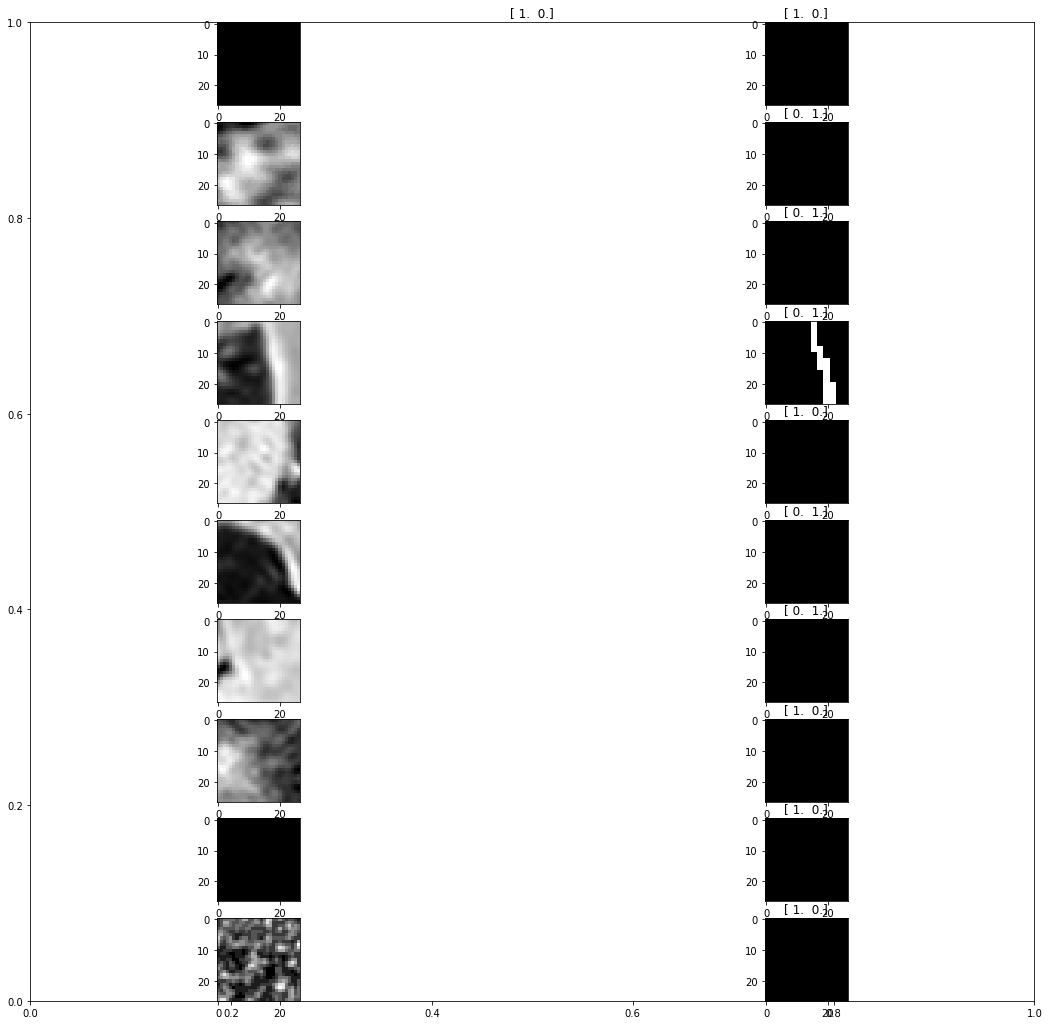

In [260]:
debug = batch_generator_debug(all_files,all_files,batch_size,patch_size)
fig = plt.figure(figsize=(18, 18))
ix= 0
train, target, label = next(debug)
train = train.astype('float32')
target = target.astype('float32')

for i in range(batch_size):
    plt.title(label[i])
    ix+=1
    ax1 = fig.add_subplot(10,2,ix)
   
    plt.imshow(train[i, 0, 6, :, :], cmap='gray')
    ix+=1
    ax1 = fig.add_subplot(10,2,ix)
    plt.title(label[i])
    plt.imshow(target[i, 6, :, :], cmap='gray')
   
    